# General Analysis for the eFEDS-XCS Paper

In this notebook we perform all of the analysis required for the eFEDS-XCS comparison paper, including generating many of the figures and tables in the paper. This analysis includes comparing eFEDS distributions to XXL measured distributions, measuring XMM temperatures and luminosities for clusters in the eFEDS-XCS sample, and fitting luminosity-temperature relations (both using XMM and eFEDS data).

The sample which we analyse in this notebook (eFEDS-XCS), only contains candidates that we consider to be galaxy clusters, and that have a high enough quality of XMM observation (more information is supplied in the paper). The sources in the eFEDS-XMM and eFEDS-XCS samples are detailed in the 'efeds_xmm.csv' and 'efeds_xcs.csv' files, and the 'excluded_cands.csv' file contains further information about which eFEDS-XMM candidates were not included in the final sample and why.

We attempt to present the code in the same order that results are presented in the paper. Any enquires about specific parts of the analysis are welcome, please contact me (D.J. Turner) at the email address provided in the paper.

## Import Statements

In [1]:
import pandas as pd
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import scipy.odr as odr
from tqdm import tqdm
from copy import deepcopy

import xga
from xga.samples.extended import ClusterSample
from xga.sources import GalaxyCluster
from xga.xspec import single_temp_apec
from xga.sas import eexpmap, emosaic
from xga.relations.fit import scaling_relation_lira, _fit_initialise
from xga.sourcetools.match import simple_xmm_match
from xga.models import straight_line, convert_to_odr_compatible, power_law
from xga import CENSUS, XSPEC_VERSION, SAS_VERSION
from xga.exceptions import ModelNotAssociatedError
from xga.products.relation import ScalingRelation

## Confirming software versions

Here we display the software versions used in this analysis:

In [2]:
print("Using SAS v{}".format(SAS_VERSION))
print("Using XSPEC v{}".format(XSPEC_VERSION))

Using SAS v17.0.0
Using XSPEC v12.10.1


## Setting up the cosmology to use

As stated in the introduction of the paper, we use a concordance ΛCDM cosmology where Ω$_\rm{M}$=0.3, Ω$_\rm{Λ}$=0.7, and H$_0$=70 km s$^{−1}$Mpc$^{−1}$, consistent with the original eFEDS cluster analysis (and other XCS works)

In [3]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Loading the samples

In this section we load the various samples required for this analysis:

### Reading in the XXL-100-GC catalogue

This is the catalogue of the brightest 100 clusters detected by the XXL survey, and is publically [available on VizieR](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=IX/49/xxl100gc&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa). It contains positional and redshift information, as long as XXL measured temperatures and luminosities. We only take clusters with the flag value equal to zero, which means that the cluster was in the original sample of 100 brightest clusters in XXL paper II, table D.

In [4]:
xxl = pd.read_csv("sample_files/xxl_gc100.csv")
xxl = xxl[xxl['Flag'] == 0]
xxl.head(10)

,XLSSC,RAJ2000,DEJ2000,z,Ngal,C60,F60,e_F60,Ez,r500MT,...,LXXL300kpc,e_LXXL300kpc,Lbol500MT,e_Lbol500MT,M500MT,e_M500MT,Mgas500,e_Mgas500,Flag,Simbad
0,94,30.648,-6.732,0.886,3,199,4.82,0.44,1.62,0.74,...,19.85,1.71,62.01,5.35,NaN,NaN,1.61,0.59,0,Simbad
1,96,30.973,-5.027,0.520,6,161,3.64,0.39,1.31,1.00,...,3.77,0.40,16.05,1.71,48.0,31.0,2.02,0.74,0,Simbad
2,102,31.322,-4.652,0.969,3,199,4.20,0.36,1.69,0.57,...,13.31,1.41,33.56,3.56,19.0,11.0,2.23,0.71,0,Simbad
3,106,31.351,-5.732,0.300,14,681,9.13,0.39,1.16,0.86,...,3.16,0.15,10.48,0.49,24.0,11.0,2.15,0.50,0,Simbad
4,107,31.354,-7.594,0.436,3,263,5.58,0.41,1.25,0.71,...,3.82,0.32,10.33,0.88,15.9,7.6,1.14,0.35,0,Simbad
5,100,31.549,-6.193,0.915,6,124,3.55,0.52,1.64,0.69,...,11.12,2.50,32.42,7.28,26.0,18.0,1.73,0.50,0,Simbad
6,93,31.699,-6.948,0.429,6,418,7.23,0.41,1.24,0.81,...,4.75,0.31,14.91,0.96,23.0,11.0,2.48,0.60,0,Simbad
7,108,31.832,-4.827,0.254,4,451,6.16,0.34,1.13,0.70,...,1.49,0.10,3.86,0.26,12.7,5.6,0.52,0.10,0,Simbad
8,95,31.962,-5.206,0.138,12,141,3.09,0.32,1.06,0.45,...,0.15,0.03,0.24,0.04,2.9,1.3,0.03,0.01,0,Simbad
9,92,32.071,-7.276,0.432,3,166,3.14,0.33,1.24,0.77,...,2.11,0.24,6.24,0.70,20.0,11.0,1.39,0.39,0,Simbad


### Reading in the eFEDS X-ray cluster candidate catalogue

We read in the eFEDS X-ray cluster candidate catalogue that is [available here](https://erosita.mpe.mpg.de/edr/eROSITAObservations/Catalogues/liuA/eFEDS_clusters_V3.fits.gz), though we have converted the file to a csv for convenience. We also alter the resulting table so that it contains $\pm$ uncertainties on $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements, rather than just confidence limits, this makes plotting and fitting easier later on in the analysis. Finally we add a 'name' column based around the 'ID_SRC' values, as the source names in the 'ID' column are not necessarily consistent between the X-ray cluster candidate and optical counterpart catalogues.

In [5]:
efeds_xray = pd.read_csv("sample_files/efeds_xray_cluster_candidates.csv")

# Changing upper and lower limits to uncertainties for 300kpc values
efeds_xray['T_300kpc-'] = efeds_xray['T_300kpc'] - efeds_xray['T_300kpc_L']
efeds_xray['T_300kpc+'] = efeds_xray['T_300kpc_U'] - efeds_xray['T_300kpc']
efeds_xray['L_300kpc-'] = efeds_xray['L_300kpc'] - efeds_xray['L_300kpc_L']
efeds_xray['L_300kpc+'] = efeds_xray['L_300kpc_U'] - efeds_xray['L_300kpc']
efeds_xray['Lbol_300kpc-'] = efeds_xray['Lbol_300kpc'] - efeds_xray['Lbol_300kpc_L']
efeds_xray['Lbol_300kpc+'] = efeds_xray['Lbol_300kpc_U'] - efeds_xray['Lbol_300kpc']

# Changing upper and lower limits to uncertainties for 500kpc values
efeds_xray['T_500kpc-'] = efeds_xray['T_500kpc'] - efeds_xray['T_500kpc_L']
efeds_xray['T_500kpc+'] = efeds_xray['T_500kpc_U'] - efeds_xray['T_500kpc']
efeds_xray['L_500kpc-'] = efeds_xray['L_500kpc'] - efeds_xray['L_500kpc_L']
efeds_xray['L_500kpc+'] = efeds_xray['L_500kpc_U'] - efeds_xray['L_500kpc']
efeds_xray['Lbol_500kpc-'] = efeds_xray['Lbol_500kpc'] - efeds_xray['Lbol_500kpc_L']
efeds_xray['Lbol_500kpc+'] = efeds_xray['Lbol_500kpc_U'] - efeds_xray['Lbol_500kpc']

efeds_xray['name'] = efeds_xray['ID_SRC'].apply(lambda x: "eFEDS-"+str(x))
efeds_xray.head(10)

,ID,ID_SRC,RA,DEC,EXT_LIKE,DET_LIKE,z,z_type,T_300kpc,T_300kpc_L,...,L_300kpc+,Lbol_300kpc-,Lbol_300kpc+,T_500kpc-,T_500kpc+,L_500kpc-,L_500kpc+,Lbol_500kpc-,Lbol_500kpc+,name
0,eFEDS J082626.6-003429,28993,126.610799,-0.574787,8.486203,5.029723,0.161110,0,-1.000000,-1.000000,...,3.544400e+42,0.000000e+00,1.626600e+43,0.000000,0.000000,0.000000e+00,3.924900e+42,0.000000e+00,1.782000e+43,eFEDS-28993
1,eFEDS J082751.8-002853,11248,126.965471,-0.481638,12.791595,27.865910,0.257160,0,-1.000000,-1.000000,...,1.019100e+43,0.000000e+00,1.721900e+43,0.000000,0.000000,0.000000e+00,1.061100e+43,0.000000e+00,1.796300e+43,eFEDS-11248
2,eFEDS J082808.8-001003,4800,127.036645,-0.167715,28.492811,62.512480,0.076155,0,0.885294,0.786329,...,3.867000e+41,5.808000e+41,5.950000e+41,0.092795,0.093866,5.040000e+41,5.816000e+41,7.621000e+41,9.367000e+41,eFEDS-4800
3,eFEDS J082820.6-000721,4169,127.085556,-0.122752,42.376125,81.378350,0.844900,0,-1.000000,-1.000000,...,3.229000e+43,8.116000e+43,1.281700e+44,0.000000,0.000000,4.183000e+43,4.533000e+43,1.117800e+44,1.806000e+44,eFEDS-4169
4,eFEDS J082840.6-000500,7991,127.169202,-0.083552,18.438711,37.515427,0.319705,0,-1.000000,-1.000000,...,2.502000e+42,6.850000e+42,7.253000e+42,0.000000,0.000000,3.347000e+42,3.113000e+42,8.181000e+42,9.381000e+42,eFEDS-7991
5,eFEDS J082900.0+010756,14973,127.249974,1.132314,19.179321,14.365816,0.354000,0,-1.000000,-1.000000,...,3.956900e+42,1.213300e+43,1.924100e+43,0.000000,0.000000,5.387000e+42,6.003000e+42,2.399600e+43,3.482100e+43,eFEDS-14973
6,eFEDS J082952.7+002140,7528,127.469684,0.361084,7.729656,38.626640,0.420000,0,-1.000000,-1.000000,...,3.770000e+42,1.021200e+43,1.561200e+43,0.000000,0.000000,3.631000e+42,4.122000e+42,1.097500e+43,1.664100e+43,eFEDS-7528
7,eFEDS J082955.5+004132,3810,127.480999,0.692199,24.177258,80.255554,0.939855,0,-1.000000,-1.000000,...,3.137000e+43,1.155100e+44,2.492700e+44,0.000000,0.000000,3.391000e+43,4.018000e+43,1.702800e+44,3.107200e+44,eFEDS-3810
8,eFEDS J083040.7+023220,9837,127.669739,2.538833,11.481833,23.703844,0.111320,0,-1.000000,-1.000000,...,2.945100e+41,3.877500e+41,4.566000e+41,0.000000,0.000000,2.519700e+41,2.993400e+41,3.895400e+41,4.713000e+41,eFEDS-9837
9,eFEDS J083110.6+015616,5601,127.794012,1.937839,11.771409,34.137924,0.419510,0,-1.000000,-1.000000,...,5.381000e+42,1.406700e+43,1.889900e+43,0.000000,0.000000,6.276000e+42,6.880000e+42,1.745500e+43,2.958500e+43,eFEDS-5601


### Reading in the eFEDS cluster candidate optical counterpart catalogue

This catalogue contains information about optical counterparts to eFEDS X-ray selected cluster candidates found by Klein et al. (2021), and is [available here](https://erosita.mpe.mpg.de/edr/eROSITAObservations/Catalogues/klein/eFEDS_c001_main_ctp_clus_v2.1.fits.gz) - again we have converted the file into a csv for convenience. We add an identical 'name' column to that which we added to the X-ray selected cluster candidate catalogue table above.

In [6]:
efeds_opt = pd.read_csv("sample_files/efeds_cluster_candidate_optical_counterparts.csv")
efeds_opt['name'] = efeds_opt['ID_SRC'].apply(lambda x: "eFEDS-"+str(x))
efeds_opt.head(10)

,Name,ID_SRC,RA_CORR,DEC_CORR,RADEC_ERR_CORR,EXT,EXT_ERR,EXT_LIKE,ML_CTS,ML_CTS_ERR,...,Alpha,Delta,Beta,Ellip,Centershift,DIST_NEXT_OPT_R500,DISTNEXT_XCLUST_MPC,DISTNEXT_XCLUST_R500,MCMF_NWAY_SECTOR,name
0,eFEDS J093712.9+031652,38,144.303568,3.281043,4.000000,26.965470,5.968361,19.696564,83.25920,16.002958,...,0.057188,0.260447,0.291617,0.599467,0.456086,8.338902,7.388609,9.777047,A,eFEDS-38
1,eFEDS J083811.9-015935,53,129.549569,-1.992963,1.381066,8.415080,0.671214,163.666980,840.92730,32.609806,...,0.131410,0.231523,0.211128,0.482397,0.258212,5.109306,6.826096,5.099522,A,eFEDS-53
2,eFEDS J093521.0+023234,82,143.837404,2.542872,2.256955,11.646078,0.921796,175.889470,789.41034,32.895790,...,0.149712,0.214348,0.227254,0.441991,0.313691,99.900002,0.914686,0.694703,A,eFEDS-82
3,eFEDS J092121.2+031726,100,140.338476,3.290604,2.786281,31.717770,1.420627,478.553300,1507.95620,56.981632,...,0.126342,0.216794,0.396560,0.548407,0.253045,99.900002,6.280532,4.680137,A,eFEDS-100
4,eFEDS J085751.7+031039,108,134.465300,3.177539,5.122587,57.368830,1.696070,742.209900,2941.50220,104.567130,...,0.184382,0.298033,0.315817,0.452866,0.265861,1.704293,2.833925,2.126780,A,eFEDS-108
5,eFEDS J092647.5+050033,137,141.697954,5.009053,3.680027,34.240242,1.704842,505.366760,1269.64820,53.113010,...,0.078323,0.137997,0.315292,0.591055,0.260348,99.900002,0.315917,0.230575,A,eFEDS-137
6,eFEDS J084528.7+032739,144,131.369500,3.460887,3.187693,28.416616,1.641801,316.698500,942.22090,43.392887,...,0.130602,0.166659,0.197001,0.046051,0.254389,99.900002,19.738748,15.345604,B1,eFEDS-144
7,eFEDS J092002.2+010220,150,140.009027,1.038868,2.707373,14.811505,1.150945,179.593930,693.43646,32.079433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B1,eFEDS-150
8,eFEDS J090131.2+030057,152,135.379989,3.015696,5.006569,33.493958,1.665559,373.949920,1196.78820,51.578068,...,0.158592,0.320781,0.253769,0.489150,0.310878,0.470425,0.486326,0.427307,B1,eFEDS-152
9,eFEDS J083651.3+030002,197,129.213825,3.000636,3.505422,28.246906,3.193915,153.496120,747.97363,42.946740,...,0.150400,0.389033,0.462623,0.140946,0.269811,99.900002,0.165200,0.158356,B1,eFEDS-197


### Marking which candidates in the eFEDS X-ray catalogue are to be considered optically confirmed

For convenience, we add a column to the eFEDS X-ray selected cluster candidates table, indicating whether the optical counterpart has a F_CONT_BEST_COMB < 0.3, which is what Klein et al. (2021) consider to be optically confirmed:

In [7]:
# The names (in the style we added earlier eFEDS-xxxx) of the candidates that 
#  are considered optically confirmed
opt_conf_names = efeds_opt[efeds_opt['F_CONT_BEST_COMB'] < 0.3]['name'].values

# Adding a column to the X-ray catalogue table that describes whether the candidate is considered 
#  optically confirmed, with a default value of False
efeds_xray['opt_conf'] = False

# Setting the optically confirmed column to True, for those candidates that appear in 
#  the opt_conf_names array
efeds_xray.loc[efeds_xray[efeds_xray['name'].isin(opt_conf_names)].index, 'opt_conf'] = True

### Reading in the eFEDS-XMM sample

This consists of 62 eFEDS X-ray selected cluster candidates that have sufficient XMM coverage to be included in our initial sample - we read in a file that contains the position, name, ID_SRC, and redshift of the candidate, with those values taken from the X-ray candidate catalogue published by eFEDS.

In [8]:
efeds_xmm = pd.read_csv("sample_files/efeds-xmm_sample.csv")
efeds_xmm.head(10)

,ID_SRC,name,RA,DEC,z
0,5702,eFEDS-5702,130.295289,0.866770,0.415210
1,6605,eFEDS-6605,130.352971,0.776778,0.407500
2,1644,eFEDS-1644,130.395834,1.030562,0.506660
3,3008,eFEDS-3008,130.450684,0.819822,0.078375
4,3334,eFEDS-3334,130.507566,0.994977,0.086645
5,144,eFEDS-144,131.369500,3.460887,0.334325
6,7831,eFEDS-7831,132.272302,2.243272,0.395420
7,8602,eFEDS-8602,132.592720,0.268673,0.195760
8,1023,eFEDS-1023,132.616040,0.250854,0.196655
9,6125,eFEDS-6125,132.627176,0.558439,0.191720


### Reading in the excluded candidate notes

This file contains short notes on why we excluded specific candidates from the final eFEDS-XCS sample:

### Reading in the eFEDS-XCS sample

This is the final sample we end up with after our eyeballing process, and is what we analyse for our direct comparisons between XMM and eFEDS - again only very basic information is included in this file. This sample is a subset of the eFEDS-XMM sample, but we felt that presenting a discrete file containing only the eFEDS-XCS clusters was easier.

In [9]:
efeds_xcs = pd.read_csv("sample_files/efeds-xcs_sample.csv")
efeds_xcs.head(10)

,ID_SRC,name,RA,DEC,z
0,6605,eFEDS-6605,130.352971,0.776778,0.407500
1,144,eFEDS-144,131.369500,3.460887,0.334325
2,7831,eFEDS-7831,132.272302,2.243272,0.395420
3,1023,eFEDS-1023,132.616040,0.250854,0.196655
4,6125,eFEDS-6125,132.627176,0.558439,0.191720
5,339,eFEDS-339,133.070856,-1.025389,0.460230
6,4810,eFEDS-4810,133.129601,-1.208351,0.545660
7,1458,eFEDS-1458,133.553588,-2.356619,0.377435
8,2079,eFEDS-2079,133.696224,-1.359051,0.353250
9,569,eFEDS-569,134.086459,1.780459,0.724080


## Comparison of the eFEDS optically confirmed and XXL-100-GC catalogues

Here we generate the figure that compares distributions of eFEDS and XXL values, making sure to only use the optically confirmed eFEDS cluster candidate sample. This requirement only affects the redshift distribution as all the candidates that have published $T_{\rm{X}}$ values are in the optically confirmed sample:

<ipython-input-10-35afe2d3f2a2>:58: RuntimeWarning: Mean of empty slice
  av_frac_err = np.nanmean(cur_sample[['T_300kpc-', 'T_300kpc+']].replace(0, np.NaN).values,


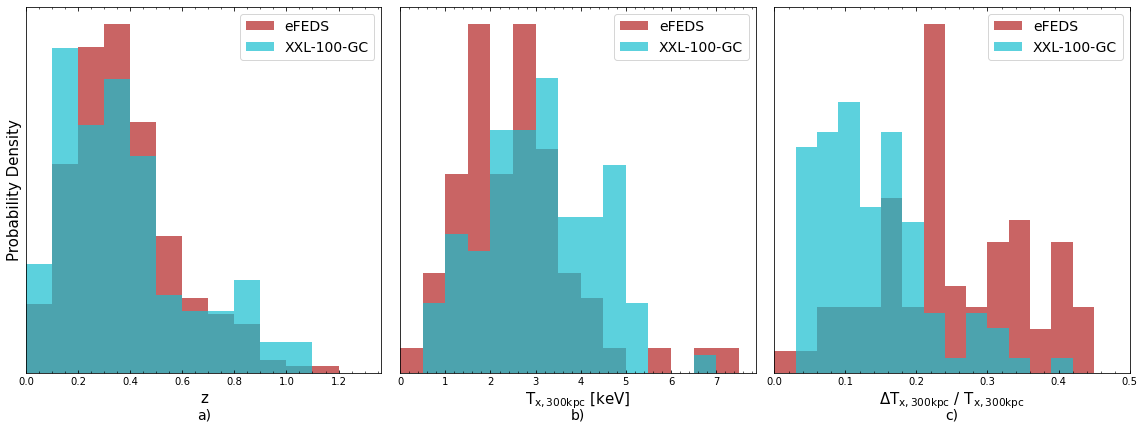

In [10]:
# Making a sub-table of the X-ray catalogue for this figure, selecting optically confirmed candidates
cur_sample = efeds_xray[efeds_xray['opt_conf']]

# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Setting the binning for the three different plots
t_frac_bins = np.arange(0, 1.05, 0.03)
z_bins = np.arange(0, 1.4, 0.1)
t_bins = np.arange(0, 8, 0.5)

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=3, figsize=(16, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
# Plotting density distributions of the XXL and eFEDs redshift samples
ax.hist(cur_sample['z'], color='firebrick', label='eFEDS', alpha=0.7, bins=z_bins, density=True, 
        histtype='stepfilled')
ax.hist(xxl['z'], color='tab:cyan', label='XXL-100-GC', alpha=0.7, bins=z_bins, density=True, 
        histtype='stepfilled')

# Labelling axes, setting labels etc.
ax.set_xlabel(r"z", fontsize=15)
ax.set_xlim(0)
ax.set_yticks([])
ax.set_ylabel("Probability Density", fontsize=15)
# Add the a) label below this first plot
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
# Plotting the density distributions of temperatures measured within a 300kpc aperture
ax.hist(cur_sample['T_300kpc'], color='firebrick', label='eFEDS', alpha=0.7, bins=t_bins, density=True, 
        histtype='stepfilled')
ax.hist(xxl['T300kpc'], color='tab:cyan', label='XXL-100-GC', alpha=0.7, bins=t_bins, density=True, 
        histtype='stepfilled')

# Setting up labels, limits etc.
ax.set_xlabel(r"T$_{\rm{x, 300kpc}}$ [keV]", fontsize=15)
ax.set_xlim(0)
ax.set_yticks([])
ax.legend(loc='best', fontsize=14)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)

# Reading out the last axis in the array of axes
ax = ax_arr[2]
# Calculating the fractional temperature errors of the eFEDS measurements, and plotting
av_frac_err = np.nanmean(cur_sample[['T_300kpc-', 'T_300kpc+']].replace(0, np.NaN).values, 
                         axis=1) /cur_sample['T_300kpc']
ax.hist(av_frac_err, bins=t_frac_bins, color='firebrick', alpha=0.7, label='eFEDS', density=True, 
        histtype='stepfilled')

# Calculating the fractional temperature errors of the XXL measurements, and plotting
xxl_frac_err = xxl['e_T300kpc'] / xxl['T300kpc']
ax.hist(xxl_frac_err, bins=t_frac_bins, color='tab:cyan', alpha=0.7, label='XXL-100-GC', density=True, 
        histtype='stepfilled')

# Setting up axis labels, limits, etc.
ax.set_xlabel(r"$\Delta \rm{T}_{\rm{x, 300kpc}}$ / $\rm{T}_{\rm{x, 300kpc}}$", fontsize=15)
ax.set_xlim(0, 0.5)
ax.set_yticks([])
ax.text(0.5, sublabel_ypos, s='c)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)

ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("output_figures/efeds_xxl_z+t+t_frac.pdf")
plt.show()

We also print the mean values of the fractional temperature uncertainties:

In [11]:
print('eFEDS mean fractional temperature uncertainty is', np.mean(av_frac_err).round(2))
print('XXL mean fractional temperature uncertainty is', np.mean(xxl_frac_err).round(2))

eFEDS mean fractional temperature uncertainty is 0.25
XXL mean fractional temperature uncertainty is 0.14


## Manually excluding some data

Here we define a dictionary that describes any data that needs to be manually disassociated from defined GalaxyCluster objects, with the reason for exclusion given in comments.

In [12]:
# The dictionary of data to remove, top level keys are source names
to_remove = {}

# We remove the 0602830401 MOS1 and MOS2 data from this source because their spectra have an extremely unusual 
#  line/feature present which does not appear in the PN spectrum
to_remove['eFEDS-372'] = {"0602830401": ["mos1", "mos2"]}

## One cluster's eFEDS properties require special consideration

This cluster appears to have been split into two pieces by the eFEDS source finder (the other part is eFEDS-8602, which **does not** appear in the eFEDS-XCS sample). As it seems likely that the eFEDS spectral analysis will have excluded the eFEDS-8602 region from the eFEDS-1023 analysis, the temperature and luminosity that they report for it is in question. It is one of the few clusters that has both an eFEDS and XMM temperature, but we do not think we can safely use it for the comparison. We do make an attempt to analyse it, by excluding eFEDS-8602 from our own spectrum generation using the extent reported in the optical counterpart catalogue.

We create a variable here so that we can easily remove/highlight measurements we make of this cluster later on:

In [13]:
split_cluster = "eFEDS-1023"

## Brief exploration of the eFEDS-XMM sample

We do not perform analysis on the objects in the eFEDs-XMM sample, but we do extract information on the XMM observations of these objects, largely to compare exposure times between XMM pointings and the eFEDS survey.

### Creating a ClusterSample for eFEDS-XMM

We do not consider all of the candidates in the eFEDS-XMM sample to be galaxy clusters, but we do define an XGA ClusterSample object so that the requirements of 70% of 300kpc aperture falling on an XMM pointing are applied:

In [14]:
ra = efeds_xmm['RA'].values
dec = efeds_xmm['DEC'].values
z = efeds_xmm['z'].values
n = efeds_xmm['name'].values

efeds_xmm_srcs = ClusterSample(ra, dec, z, n, r500=Quantity([300]*len(efeds_xmm), 'kpc'), 
                     use_peak=False, back_inn_rad_factor=2, back_out_rad_factor=3, clean_obs=True, 
                     clean_obs_reg='r500', clean_obs_threshold=0.7, load_fits=True, cosmology=cosmo)

Setting up Galaxy Clusters:   0%|          | 0/62 [00:00<?, ?it/s]/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:84: UserWarning: There are 1 alternative matches for observation 0822470101, associated with source eFEDS-5702
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:99: UserWarning: eFEDS-5702 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   2%|▏         | 1/62 [00:02<02:57,  2.91s/it]/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:99: UserWarning: eFEDS-6605 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all

Setting up Galaxy Clusters:  66%|██████▌   | 41/62 [02:02<02:17,  6.53s/it]/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:84: UserWarning: There are 1 alternative matches for observation 0725310148, associated with source eFEDS-7086
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:99: UserWarning: eFEDS-7086 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  69%|██████▉   | 43/62 [02:18<02:17,  7.22s/it]/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:84: UserWarning: There are 1 alternative matches for observation 0725310148, associated with source eFEDS-9463
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
Set

We remove any data that we manually exclude in the section above, then regenerate combined images and exposure maps to account for the removed data:

In [15]:
for n in to_remove:
    efeds_xmm_srcs[n].disassociate_obs(to_remove[n])
    
emosaic(efeds_xmm_srcs, 'image', lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
emosaic(efeds_xmm_srcs, 'expmap', lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))

### Exposure times of the eFEDS-XMM candidates

One of the figures in the paper displays the XMM exposure times of the eFEDS-XMM sample, so they can be compared to the average vignetting corrected eFEDS exposure. Here we extract the exposure times at the eFEDs coordinate both for the best single exposure, and the combined data:

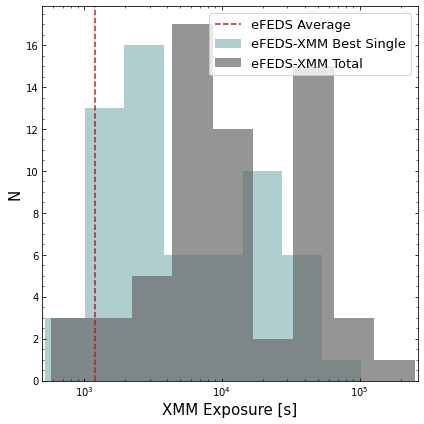

In [16]:
# Defining lists to store exposure times in
best_case_exps = []
total_exps = []

# Iterating through all of the candidates in eFEDS-XMM
for src in efeds_xmm_srcs:
    # Somewhere to store all the exposure times for a particular candidate
    all_exps = {}
    # Retrieving XMM exposure maps generated for the 0.5-2.0keV energy range
    ems = src.get_expmaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
    # This method can return a list of exposure maps, or a single exposure map (if there is only
    #  a single camera from a single observation associated with the source)
    if isinstance(ems, list):
        for em in ems:
            # We retrieve the exposure time at the eFEDS position
            all_exps[em.obs_id+em.instrument] = em.get_exp(src.ra_dec)
    else:
        em = ems
        # We retrieve the exposure time at the eFEDS position
        all_exps[em.obs_id+em.instrument] = em.get_exp(src.ra_dec)
    
    # Grabbing the combined exposure map within the same energy range
    comb_em = src.get_combined_expmaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
    # Retrieving the combined exposure time and appending the maximum individual exposure time
    total_exps.append(comb_em.get_exp(src.ra_dec).value)
    best_case_exps.append(max(all_exps.values()).value)

# Setting up the figure and altering how ticks are displayed
plt.figure(figsize=(6, 6))
plt.minorticks_on()
plt.tick_params(which='both', top=True, right=True, direction='in')

# Adding the single best exposure time and combined exposure time distributions
plt.hist(best_case_exps, bins=np.logspace(1, 5.3, 16), color='cadetblue', label='eFEDS-XMM Best Single', 
         alpha=0.5, histtype='stepfilled')
plt.hist(total_exps, bins=np.logspace(1, 5.4, 16), color='dimgrey', label='eFEDS-XMM Total', alpha=0.7, 
         histtype='stepfilled')

# Adding a vertical line for the approximate average vignetting corrected exposure time for eFEDS
plt.axvline(1200, color='firebrick', linestyle='dashed', label='eFEDS Average')

# Setting up labels, scaling etc.
plt.ylabel('N', fontsize=15)
plt.xlim(500)
plt.xlabel("XMM Exposure [s]", fontsize=15)
plt.xscale('log')
plt.legend(fontsize=13)
plt.tight_layout()
# Saving the resulting figure
plt.savefig('output_figures/xmm_exposures.pdf')
plt.show()

## First insights into the eFEDs-XCS sample

### Creating a ClusterSample for eFEDS-XCS

Setting up the ClusterSample object of our final analysis sample.

In [17]:
ra = efeds_xcs['RA'].values
dec = efeds_xcs['DEC'].values
z = efeds_xcs['z'].values
n = efeds_xcs['name'].values

efeds_xcs_srcs = ClusterSample(ra, dec, z, n, r500=Quantity([300]*len(efeds_xcs), 'kpc'), 
                     use_peak=False, back_inn_rad_factor=2, back_out_rad_factor=3, clean_obs=True, 
                     clean_obs_reg='r500', clean_obs_threshold=0.7, load_fits=True, cosmology=cosmo)

Setting up Galaxy Clusters:   0%|          | 0/37 [00:00<?, ?it/s]/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:99: UserWarning: eFEDS-6605 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   8%|▊         | 3/37 [00:04<01:02,  1.85s/it]/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:99: UserWarning: eFEDS-1023 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  22%|██▏       | 8/37 [00:09<00:29,  1.01s/it]/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:99: UserWarning: eFEDS-2079 has not been detected in all region files, so ge

Setting up Galaxy Clusters:  78%|███████▊  | 29/37 [01:46<00:35,  4.42s/it]/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:99: UserWarning: eFEDS-2004 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  81%|████████  | 30/37 [01:47<00:24,  3.46s/it]/home/dt237/code/PycharmProjects/XGA/xga/sources/general.py:99: UserWarning: eFEDS-3523 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters: 100%|██████████| 37/37 [01:54<00:00,  3.11s/it]


Again we disassociate observations that we marked for manual removal earlier in the notebook.

In [18]:
for n in to_remove:
    efeds_xcs_srcs[n].disassociate_obs(to_remove[n])
    
emosaic(efeds_xcs_srcs, 'image', lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
emosaic(efeds_xcs_srcs, 'expmap', lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))

### How many of these clusters have an eFEDS $T_{\rm{x, 300kpc}}$ or $T_{\rm{x, 500kpc}}$?

We wish to know how many of the clusters in the eFEDS-XCS sample have eFEDS temperatures that we can directly compare to, as one of the main outputs of the paper will be a direct comparison of measured temperatures.

In [19]:
cur_sample = efeds_xray[efeds_xray['name'].isin(efeds_xcs_srcs.names)]
num_t300 = len(cur_sample) - cur_sample['T_300kpc'].value_counts()[-1]
num_t500 = len(cur_sample) - cur_sample['T_500kpc'].value_counts()[-1]

print("{} of the clusters in the eFEDS-XCS sample have a valid eRASS T300kpc".format(num_t300))
print("{} of the clusters in the eFEDS-XCS sample have a valid eRASS T500kpc".format(num_t500))

7 of the clusters in the eFEDS-XCS sample have a valid eRASS T300kpc
9 of the clusters in the eFEDS-XCS sample have a valid eRASS T500kpc


### How many of these clusters have been detected by XCS?

We define detection as the eFEDS coordinate falling within an XCS extended source region.

In [20]:
num_det = 0
for src in efeds_xcs_srcs:
    if any(src.detected.values()):
        num_det += 1
print("{} of the clusters in the eFEDS-XCS sample have been detected by XCS".format(num_det))

28 of the clusters in the eFEDS-XCS sample have been detected by XCS


### How many XMM observations do the clusters have?

The left hand column indicates the number of observations, the right hand column the number of clusters in the eFEDS-XCS sample have that many XMM observations.

In [21]:
num_obs = []
for src in efeds_xcs_srcs:
    num_obs.append(len(src.obs_ids))

print(pd.value_counts(num_obs))

1    19
2    12
3     5
5     1
dtype: int64


### How many clusters have at least one on-axis XMM observation?

We define on-axis here to mean within 5 arcminutes of the pointing coordinates of the XMM observation.

In [22]:
num_onax = 0
for src in efeds_xcs_srcs:
    if len(src.on_axis_obs_ids) > 0:
        num_onax += 1
print("{} of the clusters in the eFEDS-XCS sample have at least one on-axis XMM observation".format(num_onax))

19 of the clusters in the eFEDS-XCS sample have at least one on-axis XMM observation


## Comparisons of cluster properties measured by eFEDS and XCS

This section is where we measure XMM temperatures and luminosities for the clusters in the eFEDS-XCS sample, and them compare them to eFEDs measured values. We compare distributions, like for like temperatures/luminosities, and L-T relations.

### Measuring XMM temperatures and luminosities for eFEDS-XCS clusters

Here we generate spectra and fit absorbed plasma emission models to measure temperatures and unabsorbed luminosities for 500kpc and 300kpc apertures. The XCS master source list is used to remove unwanted sources, and we choose to use the XSPEC 'aspl' abundance table, to be consistent with the eFEDS analysis (in that regard).

In [24]:
single_temp_apec(efeds_xcs_srcs, Quantity(500, 'kpc'), abund_table='aspl', timeout=Quantity(5, 'hour'))
single_temp_apec(efeds_xcs_srcs, Quantity(300, 'kpc'), abund_table='aspl', timeout=Quantity(5, 'hour'))

Running XSPEC Fits: 100%|██████████| 37/37 [11:40<00:00, 18.93s/it] 


### Storing eFEDS and XMM properties in arrays

Temperatures and luminosities measured by XGA are stored within the ClusterSample object, but we extract them into arrays of AstroPy quantities for convenience. We do the same thing with the eFEDS values.

In [53]:
# Extract the temperatures measured within 500kpc apertures, and the names of those clusters 
#  that have valid temperatures
xga_t500 = efeds_xcs_srcs.Tx(Quantity(500, 'kpc'), quality_checks=True)
good_t500_names = efeds_xcs_srcs.names[np.where(np.isfinite(xga_t500[:, 0]))[0]]

# Extract the luminosities measured within 500kpc apertures, for 0.5-2.0keV energy band
xga_l500 = efeds_xcs_srcs.Lx(Quantity(500, 'kpc'), quality_checks=True)

# Make a sub-table of the eFEDS X-ray cluster candidate catalogue, with the order
#  the same as the order in the XGA ClusterSample (guaranteed by the changing of the index and the use
#  of .loc)
cur_sample = efeds_xray[efeds_xray['name'].isin(efeds_xcs_srcs.names)].set_index('name')
cur_sample = cur_sample.loc[efeds_xcs_srcs.names]

# We also modify this sub-dataframe to replace the -1 values used by eFEDS to indicate 
#  an invalid measurement, with numpy NaN values
cur_sample.loc[:, ['T_500kpc', 'L_500kpc']] = cur_sample[['T_500kpc', 'L_500kpc']].replace(-1, np.NaN)

# Read out the eFEDS temperature and luminosity values into AstroPy quantities
erosita_t500 = Quantity(cur_sample[['T_500kpc', 'T_500kpc-', 'T_500kpc+']], 'keV')
erosita_l500 = Quantity(cur_sample[['L_500kpc', 'L_500kpc-', 'L_500kpc+']], 'erg/s')

# This shouldn't really be necessary but we make sure that every eFEDS entry with a NaN 
#  measurement also has NaN uncertainties
erosita_l500[np.where(np.isnan(erosita_l500.value))[0], :] = np.NaN
erosita_t500[np.where(np.isnan(erosita_t500.value))[0], :] = np.NaN

### Defining a fitting function based on LIRA

This will be used to fit relations between XMM and eFEDS temperatures and luminosities, to see whether they are consistent with 1:1 relations. It is largely identical to the XGA scaling_relation_lira() function, but modified to support the freezing of the slope at 1.

In [56]:
def lira_fixed_slope(y_values: Quantity, y_errs: Quantity, x_values: Quantity, x_errs: Quantity = None,
                     y_norm: Quantity = None, x_norm: Quantity = None, x_lims: Quantity = None, 
                     y_name: str = 'Y', x_name: str = 'X', num_steps: int = 100000, num_chains: int = 4, 
                     num_burn_in: int = 10000):
    try:
        from rpy2.robjects.packages import importr
        from rpy2 import robjects
        robjects.r['options'](warn=-1)
    except ImportError:
        raise XGAOptionalDependencyError('LIRA is an R fitting package, and as such you need to have installed '
                                         'rpy2 to use this function')

    # We use the rpy2 module to interface with an underlying R installation, and import the basic R components
    base_pack = importr('base')
    utils_pack = importr('utils')

    # Now we import the thing we're actually interested in, the LIRA package
    try:
        lira_pack = importr('lira')
    except robjects.packages.PackageNotInstalledError:
        raise XGAOptionalDependencyError('While the rpy2 module is installed, you do not appear to have installed '
                                         'the LIRA fitting package to your R environment')

    # Slightly different data preparation to the other fitting methods, this one returns logged data and errors
    x_fit_data, x_fit_errs, y_fit_data, y_fit_errs, x_norm, y_norm = _fit_initialise(y_values, y_errs, x_values,
                                                                                     x_errs, y_norm, x_norm, True)

    # And now we have to make some R objects so that we can pass it through our R interface to the LIRA package
    x_fit_data = robjects.FloatVector(x_fit_data.value)
    y_fit_data = robjects.FloatVector(y_fit_data.value)
    x_fit_errs = robjects.FloatVector(x_fit_errs.value)
    y_fit_errs = robjects.FloatVector(y_fit_errs.value)
    
    # This runs the LIRA fit and grabs the output data frame, from that I can read the chains for the different
    #  parameters
    chains = lira_pack.lira(x_fit_data, y_fit_data, delta_x=x_fit_errs, delta_y=y_fit_errs, n_iter=num_steps,
                            n_chains=num_chains, n_adapt=num_burn_in, export=False, print_summary=False,
                            print_diagnostic=False, beta_YIZ=1.)[0][0]

    # Read out the alpha parameter chain and convert to a numpy array
    alpha_par_chain = np.power(10, np.array(chains.rx2['alpha.YIZ']))
    alpha_par_val = np.mean(alpha_par_chain)
    alpha_par_err = np.std(alpha_par_chain)

    # Read out the beta parameter chain and convert to a numpy array
    beta_par_chain = np.array(chains.rx2['beta.YIZ'])
    beta_par_val = np.mean(beta_par_chain)
    beta_par_err = np.std(beta_par_chain)
    
    # Read out the intrinsic scatter chain and convert to a numpy array
    sigma_par_chain = np.array(chains.rx2['sigma.YIZ.0'])
    sigma_par_val = np.mean(sigma_par_chain)
    sigma_par_err = np.std(sigma_par_chain)

    fit_par = np.array([beta_par_val, alpha_par_val])
    fit_par_err = np.array([beta_par_err, alpha_par_err])

    # This call to the fit initialisation function DOESN'T produce logged data, do this so the plot works
    #  properly - it expects non logged data
    x_fit_data, x_fit_errs, y_fit_data, y_fit_errs, x_norm, y_norm = _fit_initialise(y_values, y_errs, x_values,
                                                                                     x_errs, y_norm, x_norm)

    # I'm re-formatting the chains into a shape that the ScalingRelation class will understand.
    xga_chains = np.concatenate([beta_par_chain.reshape(len(beta_par_chain), 1),
                                 alpha_par_chain.reshape(len(alpha_par_chain), 1)], axis=1)

    sr = ScalingRelation(fit_par, fit_par_err, power_law, x_norm, y_norm, x_name, y_name, 'LIRA', 
                         x_fit_data * x_norm, y_fit_data * y_norm, x_fit_errs * x_norm, 
                         y_fit_errs * y_norm, chains=xga_chains, x_lims=x_lims, 
                         scatter_par=np.array([sigma_par_val, sigma_par_err]),
                         scatter_chain=sigma_par_chain)

    return sr

### Directly comparing XMM and eFEDS luminosities

Here we make like-for-like comparisons of luminosities measured for the clusters in the eFEDS-XCS sample, and fit two models to see whether they are consistent with a 1:1 relationship. We could use the resulting XGA ScalingRelation objects to view the comparison plots, but instead we extract the parameter chains and manually make a comparison plot as its easier to adjust how it looks for publication:

In [59]:
xmm_vals = xga_l500[:, 0]
xmm_errs = xga_l500[:, 1:]

eros_vals = erosita_l500[:, 0]
eros_errs = erosita_l500[:, 1:]

eros_xmm_l500 = scaling_relation_lira(eros_vals, eros_errs, xmm_vals, xmm_errs, Quantity(1e+43,'erg/s'), 
                                      Quantity(1e+43,'erg/s'), 
                                      y_name=r'L$^{\:\rm{eFEDS}}_{\:\rm{x, 500kpc, 0.5-2.0}}$', 
                                      x_name=r'L$^{\:\rm{XGA}}_{\:\rm{x, 500kpc, 0.5-2.0}}$')

/home/dt237/code/PycharmProjects/XGA/xga/relations/fit.py:71: UserWarning: 7 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


  |**************************************************| 100%


We display median parameter values, as well as 68% confidence limits, for the model parameters:

In [69]:
print('SLOPE')
par_med = np.percentile(eros_xmm_l500.chains[:,0], 50)
print(par_med)
print(np.percentile(eros_xmm_l500.chains[:,0], 84.1)-par_med)
print(par_med-np.percentile(eros_xmm_l500.chains[:,0], 15.9))
print('')
print('NORM')
par_med = np.percentile(eros_xmm_l500.chains[:,1], 50)
print(par_med)
print(np.percentile(eros_xmm_l500.chains[:,1], 84.1)-par_med)
print(par_med-np.percentile(eros_xmm_l500.chains[:,1], 15.9))
print('')
print('SCATTER')
scatter_med = np.percentile(eros_xmm_l500.scatter_chain, 50)
print(scatter_med)
print(np.percentile(eros_xmm_l500.scatter_chain, 84.1)-scatter_med)
print(scatter_med-np.percentile(eros_xmm_l500.scatter_chain, 15.9))

SLOPE
0.910439162977878
0.05110211155471245
0.05043608254438148

NORM
1.267120850474106
0.13989819397612102
0.1302215883270994

SCATTER
0.09733774892757026
0.028974331737823752
0.02463814421770251


In [60]:
xmm_vals = xga_l500[:, 0]
xmm_errs = xga_l500[:, 1:]

eros_vals = erosita_l500[:, 0]
eros_errs = erosita_l500[:, 1:]

eros_xmm_l500_fixed = lira_fixed_slope(eros_vals, eros_errs, xmm_vals, xmm_errs, Quantity(1e+43,'erg/s'), 
                                      Quantity(1e+43,'erg/s'), 
                                       y_name=r'L$^{\:\rm{eFEDS}}_{\:\rm{x, 500kpc, 0.5-2.0}}$', 
                                       x_name=r'L$^{\:\rm{XGA}}_{\:\rm{x, 500kpc, 0.5-2.0}}$')

  |**************************************************| 100%


Again we display parameter values:

In [70]:
print('NORM')
par_med = np.percentile(eros_xmm_l500_fixed.chains[:,1], 50)
print(par_med)
print(np.percentile(eros_xmm_l500_fixed.chains[:,1], 84.1)-par_med)
print(par_med-np.percentile(eros_xmm_l500_fixed.chains[:,1], 15.9))
print('')
print('SCATTER')
scatter_med = np.percentile(eros_xmm_l500_fixed.scatter_chain, 50)
print(scatter_med)
print(np.percentile(eros_xmm_l500_fixed.scatter_chain, 84.1)-scatter_med)
print(scatter_med-np.percentile(eros_xmm_l500_fixed.scatter_chain, 15.9))

NORM
1.0759520522521924
0.06404574267021879
0.06081845146835363

SCATTER
0.10636289686514999
0.02788242435383209
0.023259292248523106


Here we make the direct comparison plot for the $L^{\rm{0.5-2.0keV}}_{\rm{X, 500kpc}}$ values measured by eFEDS and XGA, including the two models that we just fit to the data:

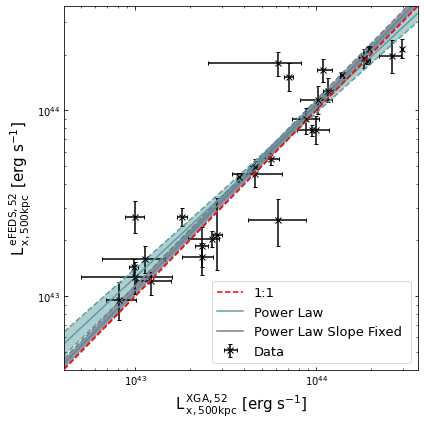

In [150]:
# A numpy random object used for the drawing of random samples 
rng = np.random.default_rng()

# Selecting only those clusters that have a valid measurement from XGA and eFEDS
both_ind = np.where(np.isfinite(xga_l500[:, 0]) & np.isfinite(erosita_l500[:, 0]))[0]
chos_xga = xga_l500[both_ind, :].value
chos_erosita = erosita_l500[both_ind, :].value

# Finding the lower and upper limits of the two datasets, then adding a 20% buffer
llim = min(np.nanmin(chos_xga[:, 0]-chos_xga[:, 1]), np.nanmin(chos_erosita[:, 0]-chos_erosita[:, 1]))*0.8
ulim = max(np.nanmax(chos_xga[:, 0]+chos_xga[:, 2]), np.nanmax(chos_erosita[:, 0]+chos_erosita[:, 2]))*1.2

# Setting up a list containing the limits, and then a linear space to use as x-values at 
#  which we can sample the models
lims = [llim, ulim]
x_vals = np.linspace(*lims, 100)

# Setting up the matplotlib figure the plot will live in, and setting tick appearance
plt.figure(figsize=(6., 6.))
plt.minorticks_on()
plt.tick_params(right=True, top=True, direction='in', which='both')

# Plotting a 1:1 line using the limits we decided on earlier
plt.plot(lims, lims, color='red', linestyle='dashed', label='1:1', zorder=10)

# Plotting the data points (and their uncertainties)
plt.errorbar(chos_xga[:, 0], chos_erosita[:, 0],xerr=[chos_xga[:, 1], chos_xga[:, 2]], 
             yerr=[chos_erosita[:, 1], chos_erosita[:, 2]], capsize=2, fmt='kx', label='Data')

# Reading out chains and generating random realisations of the power-law model fitted to the
#  luminosity comparison, then finding the median model values (as well as 68% confidence limits)
all_inds = np.arange(eros_xmm_l500._chains.shape[0])
chosen_inds = rng.choice(all_inds, 10000)
par_dists = [eros_xmm_l500._chains[:, 0][chosen_inds], eros_xmm_l500._chains[:, 1][chosen_inds]]
realisations = eros_xmm_l500.model_func(x_vals[..., None]/eros_xmm_l500.x_norm.value, *par_dists)*eros_xmm_l500.x_norm.value
median_model = np.percentile(realisations, 50, axis=1)
upper_model = np.percentile(realisations, 84.1, axis=1)
lower_model = np.percentile(realisations, 15.9, axis=1)

# Plotting the power-law model, as well as the confidence limits
plt.plot(x_vals, median_model, color='cadetblue', label='Power Law')
plt.fill_between(x_vals, lower_model, upper_model, alpha=0.5, interpolate=True,
                     where=upper_model >= lower_model, facecolor='cadetblue')
plt.plot(x_vals, lower_model, color='cadetblue', linestyle="dashed")
plt.plot(x_vals, upper_model, color='cadetblue', linestyle="dashed")

# Repeating the process for the fixed-slope model
par_dists = [eros_xmm_l500_fixed._chains[:, 0][chosen_inds], eros_xmm_l500_fixed._chains[:, 1][chosen_inds]]
realisations = eros_xmm_l500_fixed.model_func(x_vals[..., None]/eros_xmm_l500_fixed.x_norm.value, *par_dists)*eros_xmm_l500_fixed.x_norm.value
median_model = np.percentile(realisations, 50, axis=1)
upper_model = np.percentile(realisations, 84.1, axis=1)
lower_model = np.percentile(realisations, 15.9, axis=1)

plt.plot(x_vals, median_model, color="slategray", label='Power Law Slope Fixed ')
plt.fill_between(x_vals, lower_model, upper_model, alpha=0.8, interpolate=True,
                     where=upper_model >= lower_model, facecolor="slategray")
plt.plot(x_vals, lower_model, color="slategray", linestyle="dashed")
plt.plot(x_vals, upper_model, color="slategray", linestyle="dashed")

# Setting the x and y axis limits
plt.xlim(lims)
plt.ylim(lims)

# Setting axis labels, and the scale of the axes
plt.ylabel(r'L$^{\:\rm{eFEDS, 52}}_{\:\rm{x, 500kpc}}$ [erg s$^{-1}$]', fontsize=15)
plt.xlabel(r'L$^{\:\rm{XGA, 52}}_{\:\rm{x, 500kpc}}$ [erg s$^{-1}$]', fontsize=15)
plt.xscale('log')
plt.yscale('log')

# Adding in the legend
plt.legend(fontsize=13)
plt.tight_layout()
# Saving and displaying the plot
plt.savefig("output_figures/efeds_xcs_l500cal.pdf")
plt.show()

We also print the number of clusters that have successful luminosity measurements by eFEDS and XGA:

In [63]:
both_ind = np.where(np.isfinite(xga_l500[:, 0]) & np.isfinite(erosita_l500[:, 0]))[0]
print('There are {n} clusters in the eFEDS-XCS sample with 0.5-2.0keV L500 values '\
      'from XGA and eFEDS'.format(n=len(both_ind)))

There are 30 clusters in the eFEDS-XCS sample with 0.5-2.0keV L500 values from XGA and eFEDS


Finally we create two plots to directly compare the magnitude of the upper and lower uncertainties on the luminosity measurements:

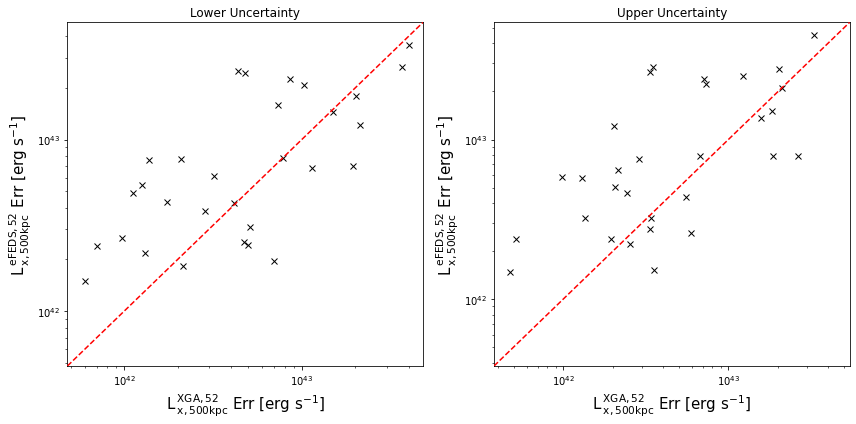

In [74]:
# Define the figure with two subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Find clusters where both luminosity measured by eFEDS and by XGA is valid
both_ind = np.where(np.isfinite(xga_l500[:, 0]) & np.isfinite(erosita_l500[:, 0]))[0]

# Read out those lums
chos_xga = xga_l500[both_ind, :].value
chos_erosita = erosita_l500[both_ind, :].value

# Setup the limits of the plot
llim = min(np.nanmin(chos_xga[:, 1]), np.nanmin(chos_erosita[:, 1]))*0.8
ulim = max(np.nanmax(chos_xga[:, 1]), np.nanmax(chos_erosita[:, 1]))*1.2
lims = [llim, ulim]

# Plot the -err comparison
ax = ax_arr[0]
ax.set_title('Lower Uncertainty')
ax.plot(lims, lims, color='red', linestyle='dashed', label='1:1', zorder=10)
ax.plot(chos_xga[:, 1], chos_erosita[:, 1], 'x', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel(r'L$^{\:\rm{eFEDS, 52}}_{\:\rm{x, 500kpc}}$ Err [erg s$^{-1}$]', fontsize=15)
ax.set_xlabel(r'L$^{\:\rm{XGA, 52}}_{\:\rm{x, 500kpc}}$ Err [erg s$^{-1}$]', fontsize=15)

llim = min(np.nanmin(chos_xga[:, 2]), np.nanmin(chos_erosita[:, 2]))*0.8
ulim = max(np.nanmax(chos_xga[:, 2]), np.nanmax(chos_erosita[:, 2]))*1.2
lims = [llim, ulim]

# Plot the +err comparison
ax = ax_arr[1]
ax.set_title('Upper Uncertainty')
ax.plot(lims, lims, color='red', linestyle='dashed', label='1:1', zorder=10)
ax.plot(chos_xga[:, 2], chos_erosita[:, 2], 'x', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel(r'L$^{\:\rm{eFEDS, 52}}_{\:\rm{x, 500kpc}}$ Err [erg s$^{-1}$]', fontsize=15)
ax.set_xlabel(r'L$^{\:\rm{XGA, 52}}_{\:\rm{x, 500kpc}}$ Err [erg s$^{-1}$]', fontsize=15)

# Display the plots
plt.tight_layout()
plt.show()

### Comparing eFEDs and XMM temperature distributions

The eFEDS-XCS sample contains a very limited number of clusters that have both an XMM and eFEDs temperature measurement, and as such when we compare the temperature and fractional temperature uncertainty distributions (as we did for XXL) we cannot restrict ourselves to only those clusters. As such we compare the whole eFEDS X-ray selected cluster candidate catalogue (those with temperature measurements anyway) to the eFEDS-XCS sample. In both cases we omit the split cluster that we mentioned earlier in the notebook:

In [76]:
split_cluster

'eFEDS-1023'

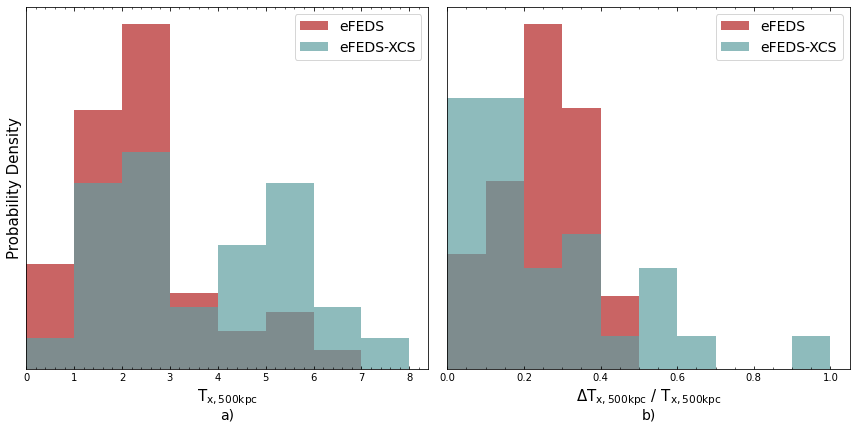

In [102]:
# Setting up a sub-table of the eFEDS X-ray cluster candidate catalogue for sources that have 
#  temperatures measured within 500kpc apertures, and aren't eFEDS-1023
cur_sample = efeds_xray[(efeds_xray['T_500kpc'] != -1) & (efeds_xray['name'] != split_cluster)]

# Setting up a subset of the XGA measured eFEDS-XCS temperatures that contains successful measurements, 
#  and does not contain eFEDS-1023
cur_xga_t500 = xga_t500[np.where(efeds_xcs_srcs.names != split_cluster)[0]]
cur_xga_t500 = cur_xga_t500[np.where(np.isfinite(cur_xga_t500[:, 0]))[0], :]

# The y position and fontsize of the a and b labels added beneath the two figures
sublabel_ypos = -0.125
sublabel_fsize = 14

# Setup the figure 
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Setup the axes ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Read out the left hand plot axis object
ax = ax_arr[0]  
# Plot the temperature distributions of the eFEDS-XCS and eFEDS X-ray cluster candidate catalogue
ax.hist(cur_sample['T_500kpc'].values, color='firebrick', label='eFEDS', alpha=0.7, bins=np.arange(0, 9, 1), 
        density=True, histtype='stepfilled')
ax.hist(cur_xga_t500[:, 0].value, color='cadetblue', label='eFEDS-XCS', alpha=0.7, bins=np.arange(0, 9, 1), 
         density=True, histtype='stepfilled')

# Set axis labels, limits, etc.
ax.set_xlabel(r"T$_{\rm{x}, 500kpc}$", fontsize=15)
ax.set_xlim(0)
ax.set_yticks([])
ax.set_ylabel("Probability Density", fontsize=15)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Read out the right hand plot axis object
ax = ax_arr[1]

# Calculate and plot the eFEDS fractional temperature errors for the 500kpc aperture
av_frac_err = np.nanmean(cur_sample[['T_500kpc-', 'T_500kpc+']].values, axis=1) /cur_sample['T_500kpc']
ax.hist(av_frac_err, bins=np.arange(0, 1.01, 0.1), color='firebrick', alpha=0.7, label='eFEDS', 
         density=True, histtype='stepfilled')

# Calculate and plot the XMM fractional temperature errors for the 500kpc aperture (eFEDS-XCS sample)
xga_frac_err = np.nanmean(cur_xga_t500[:, 1:], axis=1) / cur_xga_t500[:, 0]
ax.hist(xga_frac_err.value, color='cadetblue', label='eFEDS-XCS', alpha=0.7, bins=np.arange(0, 1.01, 0.1), 
         density=True, histtype='stepfilled')

# Set axis labels, limits, etc.
ax.set_xlabel(r"$\Delta \rm{T}_{\rm{x, 500kpc}}$ / $\rm{T}_{\rm{x, 500kpc}}$", fontsize=15)
ax.set_xlim(0)
ax.set_yticks([])
ax.legend(loc='best', fontsize=14)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)

plt.tight_layout()
# Save and display figure
plt.savefig("output_figures/efeds_xcs_txcomp.pdf")
plt.show()

### Directly comparing XMM and eFEDS temperatures

A very similar process to the direct luminosity comparison, only with fewer clusters to compare. We again fit two different models to quantify any difference from a 1:1 relation between the two datasets. 

We do not include the split cluster, eFEDS-1023, in this comparison fit.

First a power-law:

In [105]:
# Setting up a subset of the XGA measured eFEDS-XCS temperatures that contains successful measurements, 
#  and does not contain eFEDS-1023
not_split_inds = np.where(efeds_xcs_srcs.names != split_cluster)[0]
cur_xga_t500 = xga_t500[not_split_inds, :]
# Doing the same for the eROSITA data - as these arrays have an identical order I can use the same indices
cur_erosita_t500 = erosita_t500[not_split_inds, :]

eros_vals = cur_erosita_t500[:, 0]
eros_errs = cur_erosita_t500[:, 1:]

xmm_vals = cur_xga_t500[:, 0]
xmm_errs = cur_xga_t500[:, 1:]

eros_xmm_t500 = scaling_relation_lira(eros_vals, eros_errs, xmm_vals, xmm_errs, Quantity(1,'keV'), 
                                      Quantity(1, 'keV'), y_name=r"eFEDS T$_{\rm{x,500kpc}}$", 
                                      x_name=r"XGA T$_{\rm{x,500kpc}}$")

/home/dt237/code/PycharmProjects/XGA/xga/relations/fit.py:71: UserWarning: 28 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


  |**************************************************| 100%


Again we display median and 68% confidence limit model parameter values for the fit:

In [118]:
print('SLOPE')
par_med = np.percentile(eros_xmm_t500.chains[:,0], 50)
print(par_med)
par_upp = np.percentile(eros_xmm_t500.chains[:,0], 84.1)-par_med
print(par_upp)
par_low = par_med-np.percentile(eros_xmm_t500.chains[:,0], 15.9)
print(par_low)
# In this case we also store a variable with LaTeX code, as this will be presented in the paper
t_slope_str = "${v}^{u}_{l}$".format(v=par_med.round(2), u="{+"+str(par_upp.round(2))+"}", 
                                     l="{-"+str(par_low.round(2))+"}")
print('')

print('NORM')
par_med = np.percentile(eros_xmm_t500.chains[:,1], 50)
print(par_med)
par_upp = np.percentile(eros_xmm_t500.chains[:,1], 84.1)-par_med
print(par_upp)
par_low = par_med-np.percentile(eros_xmm_t500.chains[:,1], 15.9)
print(par_low)
t_norm_str = "${v}^{u}_{l}$".format(v=par_med.round(2), u="{+"+str(par_upp.round(2))+"}", 
                                    l="{-"+str(par_low.round(2))+"}")

print('')
print('SCATTER')
scatter_med = np.percentile(eros_xmm_t500.scatter_chain, 50)
print(scatter_med)
scatter_upp = np.percentile(eros_xmm_t500.scatter_chain, 84.1)-scatter_med
print(scatter_upp)
scatter_low = scatter_med-np.percentile(eros_xmm_t500.scatter_chain, 15.9)
print(scatter_low)
t_scatter_str = "${v}^{u}_{l}$".format(v=scatter_med.round(2), u="{+"+str(scatter_upp.round(2))+"}", 
                                       l="{-"+str(scatter_low.round(2))+"}")

SLOPE
0.9002916517401278
0.24576588409031452
0.23821584923028272

NORM
0.8716096720947129
0.37244240036593856
0.27525196980866384

SCATTER
0.04396268294477895
0.06321199478542781
0.027319665566435333


Then we fit a power-law with the slope fixed to one:

In [120]:
# Setting up a subset of the XGA measured eFEDS-XCS temperatures that contains successful measurements, 
#  and does not contain eFEDS-1023
not_split_inds = np.where(efeds_xcs_srcs.names != split_cluster)[0]
cur_xga_t500 = xga_t500[not_split_inds, :]
# Doing the same for the eROSITA data - as these arrays have an identical order I can use the same indices
cur_erosita_t500 = erosita_t500[not_split_inds, :]

eros_vals = cur_erosita_t500[:, 0]
eros_errs = cur_erosita_t500[:, 1:]

xmm_vals = cur_xga_t500[:, 0]
xmm_errs = cur_xga_t500[:, 1:]

eros_xmm_t500_fixed = lira_fixed_slope(eros_vals, eros_errs, xmm_vals, xmm_errs, Quantity(1,'keV'), 
                                       Quantity(1, 'keV'), y_name=r"eFEDS T$_{\rm{x,500kpc}}$", 
                                       x_name=r"XGA T$_{\rm{x,500kpc}}$")

/home/dt237/code/PycharmProjects/XGA/xga/relations/fit.py:71: UserWarning: 28 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


  |**************************************************| 100%


Displaying the parameter median and 68% confidence limit values:

In [154]:
print('NORM')
par_med = np.percentile(eros_xmm_t500_fixed.chains[:, 1], 50)
print(par_med)
par_upp = np.percentile(eros_xmm_t500_fixed.chains[:, 1], 84.1)-par_med
print(par_upp)
par_low = par_med-np.percentile(eros_xmm_t500_fixed.chains[:,1], 15.9)
print(par_low)
tfix_norm_str = "${v}^{u}_{l}$".format(v=par_med.round(2), u="{+"+str(par_upp.round(2))+"}", 
                                       l="{-"+str(par_low.round(2))+"}")

print('')
print('SCATTER')
scatter_med = np.percentile(eros_xmm_t500_fixed.scatter_chain, 50)
print(scatter_med)
scatter_upp = np.percentile(eros_xmm_t500_fixed.scatter_chain, 84.1)-scatter_med
print(scatter_upp)
scatter_low = scatter_med-np.percentile(eros_xmm_t500_fixed.scatter_chain, 15.9)
print(scatter_low)
tfix_scatter_str = "${v}^{u}_{l}$".format(v=scatter_med.round(2), u="{+"+str(scatter_upp.round(2))+"}", 
                                          l="{-"+str(scatter_low.round(2))+"}")

NORM
0.7528655453232669
0.09611256550237979
0.08409082700368287

SCATTER
0.03776543094402753
0.05118096274611066
0.02217591651687205


Here we make the direct comparison plot for the $T_{\rm{X, 500kpc}}$ values measured by eFEDS and XGA, including the two models that we just fit to the data:

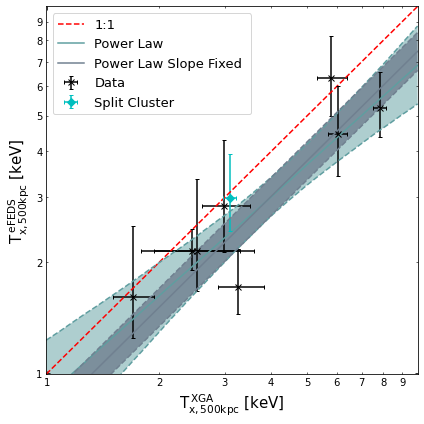

In [143]:
# Setting up a subset of the XGA measured eFEDS-XCS temperatures that contains successful measurements, 
#  and does not contain eFEDS-1023
not_split_inds = np.where(efeds_xcs_srcs.names != split_cluster)[0]
chos_xga = xga_t500[not_split_inds, :].value
# Doing the same for the eROSITA data - as these arrays have an identical order I can use the same indices
chos_erosita = erosita_t500[not_split_inds, :].value

# Reading out the values that we did the comparison model fits with, selecting only those that have
#  a valid measurement from eFEDS and XGA
both_ind = np.where(np.isfinite(chos_xga[:, 0]) & np.isfinite(chos_erosita[:, 0]))[0]
chos_xga = chos_xga[both_ind, :]
chos_erosita = chos_erosita[both_ind, :]

# Finding the max and min data limits, then adding a 20% buffer
llim = min(np.nanmin(chos_xga[:, 0]-chos_xga[:, 1]), np.nanmin(chos_erosita[:, 0]-chos_erosita[:, 1]))*0.8
ulim = max(np.nanmax(chos_xga[:, 0]+chos_xga[:, 2]), np.nanmax(chos_erosita[:, 0]+chos_erosita[:, 2]))*1.2
lims = [llim, ulim]
# Setting up x-values between the axis limits, to use to evaluate the models at
x_vals = np.linspace(*lims, 100)

# Setting up the matplotlib figure and ticks
plt.figure(figsize=(6, 6))
plt.minorticks_on()
plt.tick_params(right=True, top=True, direction='in', which='both')

# Plotting a 1:1 line
plt.plot(lims, lims, color='red', linestyle='dashed', label='1:1')
# Plotting the data (excluding eFEDS-1023 for now)
plt.errorbar(chos_xga[:, 0], chos_erosita[:, 0],xerr=[chos_xga[:, 1], chos_xga[:, 2]], 
             yerr=[chos_erosita[:, 1], chos_erosita[:, 2]], capsize=2, fmt='kx', label='Data')

# Evaluating the models for plotting, as we did for the luminosity comparison, then adding to figure
all_inds = np.arange(eros_xmm_t500._chains.shape[0])
chosen_inds = rng.choice(all_inds, 10000)
par_dists = [eros_xmm_t500._chains[:, 0][chosen_inds], eros_xmm_t500._chains[:, 1][chosen_inds]]
realisations = eros_xmm_t500.model_func(x_vals[..., None]/eros_xmm_t500.x_norm.value, *par_dists)*eros_xmm_t500.x_norm.value
median_model = np.percentile(realisations, 50, axis=1)
upper_model = np.percentile(realisations, 84.1, axis=1)
lower_model = np.percentile(realisations, 15.9, axis=1)

plt.plot(x_vals, median_model, color='cadetblue', label='Power Law')
plt.fill_between(x_vals, lower_model, upper_model, alpha=0.5, interpolate=True,
                     where=upper_model >= lower_model, facecolor='cadetblue')
plt.plot(x_vals, lower_model, color='cadetblue', linestyle="dashed")
plt.plot(x_vals, upper_model, color='cadetblue', linestyle="dashed")

par_dists = [eros_xmm_t500_fixed._chains[:, 0][chosen_inds], eros_xmm_t500_fixed._chains[:, 1][chosen_inds]]
realisations = eros_xmm_t500_fixed.model_func(x_vals[..., None]/eros_xmm_t500_fixed.x_norm.value, *par_dists)*eros_xmm_t500_fixed.x_norm.value
median_model = np.percentile(realisations, 50, axis=1)
upper_model = np.percentile(realisations, 84.1, axis=1)
lower_model = np.percentile(realisations, 15.9, axis=1)
plt.plot(x_vals, median_model, color="slategray", label='Power Law Slope Fixed ')
plt.fill_between(x_vals, lower_model, upper_model, alpha=0.8, interpolate=True,
                     where=upper_model >= lower_model, facecolor="slategray")
plt.plot(x_vals, lower_model, color="slategray", linestyle="dashed")
plt.plot(x_vals, upper_model, color="slategray", linestyle="dashed")

# Adding the split cluster, eFEDS-1023, as a point in another style
split_temp_xmm = efeds_xcs_srcs['eFEDS-1023'].get_temperature(Quantity(500, 'kpc')).value
split_temp_efeds = efeds_xray[efeds_xray['name'] == 'eFEDS-1023'][['T_500kpc', 'T_500kpc-', 
                                                                   'T_500kpc+']].values[0]
plt.errorbar([split_temp_xmm[0]], [split_temp_efeds[0]], xerr=[[split_temp_xmm[1]], [split_temp_xmm[2]]], 
             yerr=[[split_temp_efeds[1]], [split_temp_efeds[2]]], capsize=2, fmt='cD', label='Split Cluster')

# Setting up axis limits and labels
plt.xlim(lims)
plt.ylim(lims)
plt.ylabel(r'T$\rm{^{\:eFEDS}_{x, 500kpc}}$ [keV]', fontsize=15)
plt.xlabel(r'T$\rm{^{\:XGA}_{x, 500kpc}}$ [keV]', fontsize=15)

# Setting up axis scaling
plt.xscale('log')
plt.yscale('log')

# Setting the formatter for the ticks, to make it look nice
ax = plt.gca()
ax.xaxis.set_minor_formatter(FuncFormatter(lambda inp, _: '{:g}'.format(inp)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda inp, _: '{:g}'.format(inp)))
ax.yaxis.set_minor_formatter(FuncFormatter(lambda inp, _: '{:g}'.format(inp)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda inp, _: '{:g}'.format(inp)))

# Displaying and saving the figure
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig("output_figures/efeds_xcs_t500cal.pdf")
plt.show()

Finally, printing the LaTeX table code for the two model fits (or rather the two lines that can be added to the table in the paper overleaf):

In [152]:
line = "{na} & {no} & {sl} & {sc}\n"
pl = line.format(na="Power Law", no=t_norm_str, sl=t_slope_str, sc=t_scatter_str)
fpl = line.format(na="Power Law Fixed Slope", no=tfix_norm_str, sl=1, sc=tfix_scatter_str)
tab_chunk = pl + "\\hline\n" + fpl + "\\hline\n"

print(tab_chunk)

Power Law & $0.87^{+0.37}_{-0.28}$ & $0.9^{+0.25}_{-0.24}$ & $0.04^{+0.06}_{-0.03}$
\hline
Power Law Fixed Slope & $0.75^{+0.1}_{-0.08}$ & 1 & $0.04^{+0.05}_{-0.02}$
\hline



## Measuring luminosity-temperature relations